In [63]:
import numpy as np
import h5py
import trimesh
import matplotlib.pyplot as plt
from random import random, uniform
import dlib
from scipy.optimize import lsq_linear

In [87]:
%run optimizers/gradient_descent.ipynb
%run initializers/pose_parameters.ipynb
%run initializers/shape_parameters.ipynb
%run features/basel_features/index_loader.ipynb
%run visualizers/model_mesh.ipynb
%run transformations/transformations.ipynb

In [88]:
class Face3DMM:
    """
    Optimizer definition for finding the optimal PCA weights to construct a 3D model from 2D image.
    """
    
    def __init__(self, basel_model_filepath):
        """
        """
        
        # load the basel model
        model = h5py.File(basel_model_filepath, 'r')
        
        # load all of the shape data
        self.shape_mean = np.array(model['shape']['model']['mean'])
        self.shape_pcaBasis = np.array(model['shape']['model']['pcaBasis'])
        self.shape_pcaVariance = np.array(model['shape']['model']['pcaVariance'])
              
        # get indexes of feature points
        feature_point_indexes = get_feature_point_indexes_f()
        
        # extract only the feature points
        self.shape_mean_features = self.shape_mean[feature_point_indexes]
        self.shape_pcaBasis_features = self.shape_pcaBasis[feature_point_indexes]
        
        # get the triangles for the model mesh
        self.triangles = np.array(model['shape']['representer']['cells'])
        
        # the number of points, features and components
        self.num_points = int(len(self.shape_mean)/3)
        self.num_features = int(len(feature_point_indexes)/3)
        self.num_components = len(self.shape_pcaVariance)
        
        # reshape the components for matrix operations
        self.shape_mean = self.shape_mean.reshape(self.shape_mean.shape+(1,))
        self.shape_mean_features = self.shape_mean_features.reshape(self.shape_mean_features.shape+(1,))
        self.shape_pcaVariance = self.shape_pcaVariance.reshape(self.shape_pcaVariance.shape+(1,))
    
    
    def get_3DMM(self, face_image):
        """
        Gets a 3DMM for an image of a face.
        
        Args:
          face_image: the image of the face
        
        Returns:
          A 3DMM for the face in the 2D image
        """
        
        # TODO
        
        return None
    
    
    def optimize(self, target_features, i=25, j=1000):
        """
        Gets optimal weights for a 3DMM reconstruction from the 2D input features.
        
        Args:
          target_features: the 2D target features [x1, y1, x2, y2, ...]            (2*f,1)
          i: the number of additional iterations for pose and shape estimations
          j: the number of optimizer iterations
          where
            f: the number of features
        
        Returns:
          Optimal weights for a 3DMM face reconstruction and SOP parameters (a, r, t, s)
        """
        
        # initial pose and shape parameters
        ri, ti, si = initialize_pose_parameters(target_features, np.zeros((self.num_components,1)), self.shape_mean_features, self.shape_pcaBasis_features)
        ai = initialize_shape_parameters(target_features, self.shape_mean_features, self.shape_pcaBasis_features, self.shape_pcaVariance, ri, ti, si)
        for _ in range(i):
            ri, ti, si = initialize_pose_parameters(target_features, ai, self.shape_mean_features, self.shape_pcaBasis_features)
            ai = initialize_shape_parameters(target_features, self.shape_mean_features, self.shape_pcaBasis_features, self.shape_pcaVariance, ri, ti, si)
        
        # return the result of the optimization
        return gradient_descent(
            target_features,
            self.shape_mean_features,
            self.shape_pcaBasis_features,
            self.shape_pcaVariance,
            ai,
            ri,
            ti,
            si,
            optimizer='adam',
            num_iterations=j)
    
    
    def get_projection_points(self, a, r, t, s, mode='all'):
        """
        Gets the 2D projections from the pca model weights.
        
        Args:
          a: the pca model weights        (c, 1)
          r: the rotation matrix          (3, 3)
          t: the translation matrix       (2, 1)
          s: the scale matrix             (1)
          mode: 'all' or 'features'
          where
            f: the number of features
            c: the number of components
        
        Returns:
          The 2D point projections         (2, n)
        """
        
        if mode.lower() == 'all':
            return project_2d(self.shape_mean, self.shape_pcaBasis, a, r, t, s)
        elif mode.lower() == 'features':
            return project_2d(self.shape_mean_features, self.shape_pcaBasis_features, a, r, t, s)
        else:
            raise Exception('model must be all or features')
            
    
    def get_model_mesh(self, a):
        """
        Gets a Trimesh object for the model mesh from the pca component weights
        
        Args:
          a: the pca model weights        (c, 1)
          where
            c: the number of components
        
        Returns:
          A Trimesh object for the model mesh
        """
        
        return get_model_mesh(model_point_combination(self.shape_mean, self.shape_pcaBasis, a), self.triangles)
    

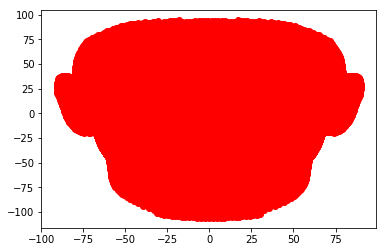

In [89]:
x = Face3DMM(basel_model_filepath='../basel/model2017-1_bfm_nomouth.h5')
weights = np.array([uniform(0, 0) for i in range(x.num_components)]).reshape((x.num_components,1))
points = x.get_projection_points(
    a=weights,
    r=np.array([
        [1,0,0],
        [0,1,0],
        [0,0,1]
    ]),
    t=np.array([0,0]).reshape((2,1)),
    s=1.,
    mode='all'
)
plt.plot(points[0,:], points[1,:], 'ro')
plt.show()

In [92]:
mesh = x.get_model_mesh(np.array([uniform(0, 0) for i in range(x.num_components)]).reshape((x.num_components,1)))
mesh.show()

In [20]:
a, r, t, s = x.optimize(points.flatten(), i=100, j=10000)
print(a.shape)
print(r)
print(t)
print(s)
test_points = x.get_projection_points(
    a=a,
    r=r,
    t=t,
    s=s,
    mode='features'
)
plt.plot(test_points[0,:], test_points[1,:], 'ro')
plt.show()

(159447, 1)
(159447, 199)
